Author
vokrut--42Robotics

In [1]:
#Import required frameworks

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
from pandas.io.json import json_normalize
import json


from google.colab import drive
drive.mount('/content/drive')

#upload json data file 
quantum_data = pd.read_json("drive/My Drive/qc/01/3125_random_5_qubit_circuits.json", orient='records', lines=True, precise_float="precise_float")
#check for missing data and/or NaN values. This will check all of the columns 
#and return True if there are any missing values or NaN, otherwise returns False                        
#quantum_data.isna().any()

#quantum_data.head(5)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def gate_data_preproc(quantum_data, gate_num):
  #since we care only about the value of the angles in U3 Gate, check for this type of gate
  #if the gate is not a U3 gate, set the angle values to 0
  is_not_u3gate = lambda data: data["Gate_Type"] != 'U3Gate'
  norm_data = json_normalize(quantum_data)
  dataframe = pd.DataFrame()  #create new data table

  #.loc[] - accesses a group of rows and columns by label(s) or a boolean array.
  norm_data.loc[(is_not_u3gate(norm_data), 'Angle_1')] = 0.0
  norm_data.loc[(is_not_u3gate(norm_data), 'Angle_2')] = 0.0
  norm_data.loc[(is_not_u3gate(norm_data), 'Angle_3')] = 0.0

  #iterate through each subcateggory, pass if GateType or GateNumber
  #store in the new table 
  for key in norm_data:
    # print(key)
    if key == 'Gate_Number' or key == 'Gate_Type':
      continue
    dataframe[key+gate_num] = norm_data[key]
    if key in ['Target', 'Control']:
      dataframe[key+gate_num] += 1
      # print(dataframe[key+gate_num])

  return dataframe

norm_qdata = json_normalize(quantum_data['statevector'])
# print(qdata.head())
#iterate in data set. where key represent a gate number on each iteration
for key in quantum_data:
  # print(key)
  if "gate" in key:                   #if key == gate, store the gate number
    gate_num = "_" + str(key[-2:])
    gate_dataframe = gate_data_preproc(quantum_data[key], gate_num)
    norm_qdata = norm_qdata.join(gate_dataframe)

#randomize data
norm_qdata = norm_qdata.reindex(
    np.random.permutation(norm_qdata.index))
#display first 10 from normalized data
norm_qdata
# display.display(norm_qdata)

,state_11111,state_10111,state_11011,state_11100,state_01001,state_01100,state_00000,state_00100,state_01000,state_11110,state_11000,state_00001,state_00111,state_00010,state_11010,state_10000,state_10110,state_10010,state_00101,state_10100,state_01111,state_11001,state_10001,state_00011,state_10101,state_01010,state_11101,state_10011,state_01110,state_01101,state_00110,state_01011,Angle_3_11,Control_11,Angle_1_11,Target_11,Angle_2_11,Angle_3_30,Control_30,Angle_2_30,...,Angle_3_14,Control_14,Angle_1_14,Target_14,Angle_2_14,Angle_3_26,Control_26,Angle_1_26,Target_26,Angle_2_26,Angle_3_07,Control_07,Angle_1_07,Target_07,Angle_2_07,Angle_3_03,Control_03,Angle_1_03,Target_03,Angle_2_03,Angle_3_21,Control_21,Angle_1_21,Target_21,Angle_2_21,Angle_3_22,Control_22,Angle_1_22,Target_22,Angle_2_22,Angle_3_36,Control_36,Angle_2_36,Target_36,Angle_1_36,Angle_3_04,Control_04,Angle_1_04,Target_04,Angle_2_04
1134,0,0,0,0,0,0,1,504,0,0,0,0,0,0,0,3,0,0,0,516,0,0,0,0,0,0,0,0,0,0,0,0,0.04110,5,0.5,0,0.750598,0.0,0,0.0,...,0.00000,3,0.0,0,0.0,0.0,0,0.0,0,0.0,1.643136,4,0.000000,0,0.0,0.000000,1,0.000000,3,0.000000,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,-0.500000,1,0.0,0,0.0
1431,0,0,0,0,0,0,125,0,433,0,424,0,0,11,10,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0.00000,1,0.0,2,0.000000,0.0,5,0.0,...,0.50000,5,0.0,0,0.0,0.0,1,0.0,0,0.0,0.244045,1,0.000000,0,0.0,0.244045,3,0.000000,0,0.000000,1.0,5,0.5,0,0.0,-0.500000,5,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,3,0.0,1,0.0
2744,0,0,0,0,0,0,1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0,0.0,0,0.000000,0.0,0,0.0,...,0.00000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,2,0.000000,0,0.0,0.000000,5,0.000000,2,0.000000,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,1.256883,2,0.0,0,0.0
2344,0,0,0,0,0,496,0,0,528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0,0.0,0,0.000000,0.0,0,0.0,...,0.00000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,4,0.000000,0,0.0,0.000000,2,0.000000,5,0.000000,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,1,0.0,0,0.0
1047,196,0,209,0,0,0,0,0,0,40,0,0,0,0,56,0,0,0,0,0,229,0,0,0,0,50,0,0,46,0,0,198,0.00000,4,0.0,3,0.000000,0.0,2,0.0,...,0.50000,4,1.0,0,0.5,1.0,5,0.5,0,0.0,0.000000,4,0.000000,3,0.0,0.000000,2,0.000000,4,0.000000,-0.5,1,0.0,0,0.0,0.000000,2,0.0,1,0.0,0.0,0,0.0,0,0.0,0.000000,4,0.0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,0,0,0,0,0,0,971,0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,1,0.0,0,0.000000,0.0,0,0.0,...,0.00000,4,0.0,0,0.0,0.0,0,0.0,0,0.0,0.500000,5,0.000000,0,0.0,0.000000,3,0.000000,1,0.000000,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,2,0.0,4,0.0
1757,0,0,0,0,0,0,1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,2,0.0,0,0.000000,0.0,0,0.0,...,0.00000,5,0.0,0,0.0,0.0,0,0.0,0,0.0,-0.629697,5,-0.405413,0,0.0,0.000000,1,0.000000,3,0.000000,0.0,0,0.0,0,0.0,0.000000,0,0.0,0,0.0,0.0,0,0.0,0,0.0,1.000000,4,0.0,0,0.0
1217,0,0,0,0,0,0,505,0,6,0,5,0,0,0,0,508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00000,1,0.5,0,0.000000,0.0,0,0.0,...,0.00000,3,0.0,4,0.0,0.0,3,0.0,0,0.0,0.000000,5,0.000000,1,0.0,0.210886,4,1.939457,0,1.436484,0.0,2,0.0,5,0.0,-0.984212,5,0.0,0,0.0,0.0,0,0.0,0,0.0,-0.032131,4,0.0,0,0.0
2084,0,0,0,0,0,0,0,0,0,0,0,0,0,1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.63941,4,0.0,0,0.000000,0.0,0,0.0,...,0.63941,4,0.0,0,0.0,0.0,0,0.0,0,0.0,1.370389,1,0.000000,0,0.0,0.042480,3,0.000000,0,0.000000,0.0,3,0.0,0,0.0,0.000000,4,0.0,0,0.0,0.0,0,0.0,0,0.0,0.000000,1,0.0,3,0.0


In [0]:
#create a dict of target classes
statevector_target = {1: 'state_11111',
                      2: 'state_10111',
                      3: 'state_11011',
                      4: 'state_11100',
                      5: 'state_01001',
                      6: 'state_01100',
                      7: 'state_00000',
                      8: 'state_00100',
                      9: 'state_01000',
                      10: 'state_11110',
                      11: 'state_11000',
                      12: 'state_00001',
                      13: 'state_00111',
                      14: 'state_00010',
                      15: 'state_11010',
                      16: 'state_10000',
                      17: 'state_10110',
                      18: 'state_10010',
                      19: 'state_00101',
                      20: 'state_10100',
                      21: 'state_01111',
                      22: 'state_11001',
                      23: 'state_10001',
                      24: 'state_00011',
                      25: 'state_10101',
                      26: 'state_01010',
                      27: 'state_11101',
                      28: 'state_10011',
                      29: 'state_01110',
                      30: 'state_01101',
                      31: 'state_00110',
                      32: 'state_01011'}

In [5]:
#analize features
print(norm_qdata.columns)

Index(['state_11111', 'state_10111', 'state_11011', 'state_11100',
       'state_01001', 'state_01100', 'state_00000', 'state_00100',
       'state_01000', 'state_11110',
       ...
       'Angle_3_36', 'Control_36', 'Angle_2_36', 'Target_36', 'Angle_1_36',
       'Angle_3_04', 'Control_04', 'Angle_1_04', 'Target_04', 'Angle_2_04'],
      dtype='object', length=237)


In [6]:
#describe data
norm_qdata.describe()

,state_11111,state_10111,state_11011,state_11100,state_01001,state_01100,state_00000,state_00100,state_01000,state_11110,state_11000,state_00001,state_00111,state_00010,state_11010,state_10000,state_10110,state_10010,state_00101,state_10100,state_01111,state_11001,state_10001,state_00011,state_10101,state_01010,state_11101,state_10011,state_01110,state_01101,state_00110,state_01011,Angle_3_11,Control_11,Angle_1_11,Target_11,Angle_2_11,Angle_3_30,Control_30,Angle_2_30,...,Angle_3_14,Control_14,Angle_1_14,Target_14,Angle_2_14,Angle_3_26,Control_26,Angle_1_26,Target_26,Angle_2_26,Angle_3_07,Control_07,Angle_1_07,Target_07,Angle_2_07,Angle_3_03,Control_03,Angle_1_03,Target_03,Angle_2_03,Angle_3_21,Control_21,Angle_1_21,Target_21,Angle_2_21,Angle_3_22,Control_22,Angle_1_22,Target_22,Angle_2_22,Angle_3_36,Control_36,Angle_2_36,Target_36,Angle_1_36,Angle_3_04,Control_04,Angle_1_04,Target_04,Angle_2_04
count,3125.00000,3125.00000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.00000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,...,3125.000000,3125.0000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.0,3125.000000,3125.0,3125.0,3125.0,3125.000000,3125.00000,3125.000000,3125.000000,3125.000000
mean,4.31136,6.48704,5.440320,10.389760,21.904640,21.527680,301.729600,70.645440,70.895360,4.796160,21.183360,75.218560,9.818240,71.248000,11.659520,73.753280,9.896320,24.461440,20.590720,23.15904,6.001600,8.175040,22.288640,23.355200,10.566720,24.221120,5.729920,12.576640,10.856000,9.777280,20.718720,10.617280,0.160400,2.869760,0.088459,0.782400,0.037538,0.019997,0.725440,0.007079,...,0.136053,2.4960,0.078139,0.659520,0.035556,0.033170,1.118400,0.026638,0.224320,0.016599,0.198562,2.946560,0.118504,0.882560,0.047618,0.277315,2.639040,0.134090,0.850880,0.043425,0.076432,1.684800,0.053384,0.435520,0.023289,0.060938,1.618880,0.044570,0.356480,0.022323,0.0,0.248320,0.0,0.0,0.0,0.261983,2.81888,0.135210,0.959360,0.032736
std,33.85683,45.55274,40.711141,63.811295,103.448676,100.585487,381.365618,198.916668,196.640008,34.982203,98.611662,206.546912,57.986175,199.348666,70.748684,202.736519,61.489957,103.800086,94.140423,100.42303,49.221113,54.362371,98.093931,103.609072,64.610409,103.422059,45.067115,67.201416,65.580539,64.113433,100.754636,63.032506,0.480760,1.666111,0.282246,1.536583,0.237262,0.175556,1.566743,0.094996,...,0.446126,1.8827,0.263402,1.464227,0.226041,0.238508,1.783782,0.157961,0.929278,0.161958,0.527471,1.313292,0.330729,1.572806,0.258365,0.592346,1.116005,0.360369,1.384997,0.247456,0.348591,1.960602,0.225969,1.260584,0.182924,0.318370,1.987886,0.207012,1.123729,0.177045,0.0,1.038827,0.0,0.0,0.0,0.546596,1.21365,0.346765,1.500943,0.226075
min,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.867883,0.000000,-0.983906,0.000000,-0.500000,-1.700741,0.000000,-0.500000,...,-1.734532,0.0000,-0.998146,0.000000,-0.500000,-1.540465,0.000000,-0.871231,0.000000,-0.500000,-1.908105,1.000000,-0.997631,0.000000,-0.500000,-1.763002,1.000000,-0.999282,0.000000,-0.500000,-1.627857,0.000000,-0.940143,0.000000,-0.500000,-1.363557,0.000000,-0.951870,0.000000,-0.500000,0.0,0.000000,0.0,0.

In [0]:
#Define and store the input features

def preprocess_features(quantum_data):
  #define features
  selected_features = quantum_data.filter(regex='^(?!state)', axis=1) #!define later
  return selected_features

#define and store the target
def preprocess_targets(quantum_data):
  output_targets = pd.DataFrame()
  output_targets = quantum_data.filter(regex='^state', axis=1) 
  output_targets /= 1024
  return output_targets

#display to male sure you are thinking correct
#display.display(preprocess_features(norm_qdata))
#display.display(preprocess_targets(norm_qdata))


In [20]:
#set training data. For now, takes only first 100 items from the data set. Increase the size later
training_feature = preprocess_features(norm_qdata.head(2185))
training_target = preprocess_targets(norm_qdata.head(2185))

#set validating data.For now, takes only last 100 items from the data set. Increase the size later
validating_feature = preprocess_features(norm_qdata.tail(100))
validating_target = preprocess_targets(norm_qdata.tail(100))


#displays features and targets
# print("Training feature")
# display.display(training_feature)

# print("Training targets")
display.display(training_target)

# print("Validating data")
# display.display(validating_feature)

,state_11111,state_10111,state_11011,state_11100,state_01001,state_01100,state_00000,state_00100,state_01000,state_11110,state_11000,state_00001,state_00111,state_00010,state_11010,state_10000,state_10110,state_10010,state_00101,state_10100,state_01111,state_11001,state_10001,state_00011,state_10101,state_01010,state_11101,state_10011,state_01110,state_01101,state_00110,state_01011
1134,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000977,0.492188,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.002930,0.0,0.0,0.0,0.503906,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1431,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.122070,0.000000,0.422852,0.000000,0.414062,0.0,0.0,0.010742,0.009766,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.020508,0.0,0.0,0.000000,0.0,0.0,0.000000
2744,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2344,0.000000,0.0,0.000000,0.0,0.0,0.484375,0.000000,0.000000,0.515625,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1047,0.191406,0.0,0.204102,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.039062,0.000000,0.0,0.0,0.000000,0.054688,0.000000,0.0,0.0,0.0,0.000000,0.223633,0.0,0.0,0.0,0.0,0.048828,0.0,0.0,0.044922,0.0,0.0,0.193359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.494141,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.505859,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2617,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.484375,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.515625,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1978,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091797,0.0,0.0,0.423828,0.000000,0.387695,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.096680,0.0,0.0,0.000000,0.0,0.0,0.000000
856,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [0]:
#Construct the TensorFlow Feature Columns.
#   Args: input_features: The names of the numerical input features to use.
#   Returns: A set of feature columns

def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    # idx = np.random.permutation(features.index)
    # raw_features = {features.reindex(idx)}
    # raw_targets = np.array(labels[idx])

    # idx = np.random.permutation(features.index)
    # print("index =", idx)
    raw_features = {key:np.array(value) for key, value in dict(features).items()}
    # print(raw_features)
    # print(type(int(i)))
    raw_targets = np.array(labels)
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def create_predict_input_fn(features, targets, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {key:np.array(value) for key, value in dict(features).items()}
    # print(raw_features)
    # print(type(int(i)))
    raw_targets = np.array(targets)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
#the following function does not fully reflect all functionality right now
#working on it

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """

  periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  
  #training input function
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create feature columns using customs function
  feature_columns = construct_feature_columns(training_examples)

  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)



  #   hidden_units: Iterable of number hidden units per layer.
  #                 All layers are fully connected. Ex. [64, 32] means first
  #                 layer has 64 nodes and second one has 32.
  # feature_columns: An iterable containing all the feature columns used by the model.
  #                  All items in the set should be instances of classes derived from _FeatureColumn.
  # model_dir: Directory to save model parameters, graph and etc.
  #            This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.
  # label_dimension: Number of regression targets per example.
  #                 This is the size of the last dimension of the labels and logits Tensor objects (typically, these have shape [batch_size, label_dimension]).
  # weight_column: A string or a _NumericColumn created by tf.feature_column.numeric_column
  #               defining feature column representing weights. It is used to down weight or boost examples during training.
  #               It will be multiplied by the loss of the example. If it is a string, it is used as a key to fetch weight tensor from the features.
  #               If it is a _NumericColumn, raw tensor is fetched by key weight_column.key, then weight_column.normalizer_fn is applied on it to get weight tensor.
  # optimizer: An instance of tf.keras.optimizers.Optimizer used to train the model.
  #            Can also be a string (one of 'Adagrad', 'Adam', 'Ftrl', 'RMSProp', 'SGD'), or callable. Defaults to Adagrad optimizer.
  # activation_fn: Activation function applied to each layer. If None, will use tf.nn.relu.
  # dropout: When not None, the probability we will drop out a given coordinate.
  # config: RunConfig object to configure the runtime settings.
  # warm_start_from: A string filepath to a checkpoint to warm-start from, or a WarmStartSettings object
  #                   to fully configure warm-starting. If the string filepath is provided instead of a WarmStartSettings,
  #                   then all weights are warm-started, and it is assumed that vocabularies and Tensor names are unchanged.
  # loss_reduction: One of tf.losses.Reduction except NONE. Describes how to reduce training loss over batch. Defaults to SUM_OVER_BATCH_SIZE.
  # batch_norm: Whether to use batch normalization after each hidden layer.

  # Create a DNNRegression object.
  # Use .train(trainig_data) to train the model
  # use .predict(predict_training_function) to make a prediction using a model
  classifier = tf.estimator.DNNRegressor(
      hidden_units=hidden_units,
      feature_columns=feature_columns,
      label_dimension=32,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    print("Period = ", period)
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute predictions.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_predictions = np.array([item['predictions'] for item in training_predictions])
    # training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    # training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
    
    error_on_training = metrics.mean_squared_error(training_predictions, training_targets)
    error_on_training = math.sqrt(error_on_training)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_predictions = np.array([item['predictions'] for item in validation_predictions])    
    # validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    # validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    error_on_validating = metrics.mean_squared_error(validation_predictions, validation_targets)
    error_on_validating = math.sqrt(error_on_validating)

    #WIP on errors and metrics!!!!

  
    # Occasionally print the current loss.
    
    print("  period %02d : %0.2f" % (period, error_on_validating))
    # Add the loss metrics from this period to our list. ??to plot the graph later??
    training_errors.append(error_on_training)
    validation_errors.append(error_on_validating)
  print("Model training finished.")
  # # Remove event files to save disk space.
  # _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  # final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  # final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  # accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  # print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("MSE")
  plt.xlabel("Periods")
  plt.title("MSE vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # # Output a plot of the confusion matrix.
  # cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # # Normalize the confusion matrix by row (i.e by the number of samples
  # # in each class).
  # cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  # ax = sns.heatmap(cm_normalized, cmap="bone_r")
  # ax.set_aspect(1)
  # plt.title("Confusion matrix")
  # plt.ylabel("True label")
  # plt.xlabel("Predicted label")
  # plt.show()

  return classifier

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f98d6db0c50>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpwoiqigop', '_session_creation_timeout_secs': 7200}
Training model...
LogLoss error (on validation data):
Period =  0
INFO:tensorflow:

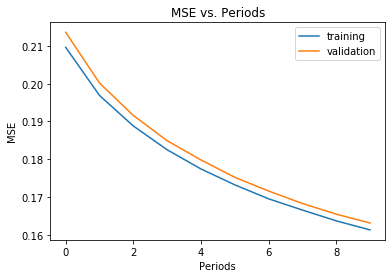

In [27]:
classifier = train_nn_classification_model(
    learning_rate=0.0001,
    steps=1000,
    batch_size=16,
    hidden_units=[1024, 1024, 1024],
    training_examples=training_feature,
    training_targets=training_target,
    validation_examples=validating_feature,
    validation_targets=validating_target)